In [1]:
import keras
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

2024-07-03 11:16:20.388377: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-03 11:16:20.390605: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-03 11:16:20.397510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 11:16:20.410374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 11:16:20.410389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 11:16:20.419490: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
data = pd.read_csv("../tb_files/data/formatted_data.csv")
data

,trackid,hitid,pt,truth,nnscore,x,y,z
0,0,0,0.986301,0,0.000000,263.937,117.795,19.9355
1,0,1,0.986301,0,0.000000,349.363,169.304,182.2330
2,0,2,0.986301,0,0.000000,488.266,267.997,164.2560
3,0,3,0.986301,0,0.000000,637.573,403.633,146.5830
4,0,4,0.986301,0,0.000000,798.729,597.984,256.2500
...,...,...,...,...,...,...,...,...
1286740,257348,0,2.138610,0,0.001823,264.445,115.347,177.9890
1286741,257348,1,2.138610,0,0.001823,373.870,156.652,240.5600
1286742,257348,2,2.138610,0,0.001823,520.914,205.937,256.6510
1286743,257348,3,2.138610,0,0.001823,710.090,258.728,356.6870


In [3]:
x_data = []
data.groupby(["trackid"])[["x","y","z"]].apply(lambda x : x_data.append(np.array(x)))
x_data = np.array(x_data) # shaped [ [[xyz],[xyz],[xyz]...], [...] ]
NHITS = 5
NPARAMS = 3
# x_data = np.reshape(x_data, (-1, NHITS*NPARAMS)) # [[xyzxyzxyzxyz],[xyzxyzxyzxyz]]
x_data = np.reshape(x_data, (-1, NHITS*NPARAMS), "F") # [[xxxxxyyyyyzzzzz],[xxxxxxyyyyyzzzzzz]]
x_data = x_data / 1000
print(x_data.shape)

y_data = data.drop_duplicates(subset=['trackid'], keep='first', inplace=False, ignore_index=True)["truth"].to_numpy()
print(y_data.shape)

(257349, 15)
(257349,)


In [4]:
print("number tracks:",len(y_data))
print("number true tracks:",len(np.where(y_data == 1)[0]))
true_prop = len(np.where(y_data == 1)[0]) / len(y_data)
print("proportion of true:",true_prop)

number tracks: 257349
number true tracks: 15313
proportion of true: 0.05950285410085137


In [5]:
# from keras.layers import Input, Dense

# def build_model(nhits=5, npars=3):
#   inputs = Input((nhits*npars,))
#   x = inputs
#   x = Dense(64, activation='relu')(x)
#   x = Dense(64, activation='relu')(x)
#   x = Dense(32, activation='relu')(x)
#   x = Dense(1, activation='sigmoid')(x)
#   return (inputs, x)

# inputs, outputs = build_model()
# model = keras.Model(inputs, outputs)
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = keras.losses.binary_crossentropy
# model.compile(optimizer, loss, metrics=["mse", "accuracy"])
# H = defaultdict(list)

In [6]:
from keras.layers import Dense

model = keras.Sequential()
model.add(keras.Input((15,)))
# model.add(Dense(64, input_shape=(15,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.binary_crossentropy
model.compile(optimizer, loss, metrics=["mse", "accuracy"])
model(keras.Input((15,))) # run with input layer?
H = defaultdict(list)

2024-07-03 11:16:25.615930: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-07-03 11:16:25.615950: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: denis-pc
2024-07-03 11:16:25.615955: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: denis-pc
2024-07-03 11:16:25.616019: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.90.7
2024-07-03 11:16:25.616035: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.67.0
2024-07-03 11:16:25.616039: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 550.67.0 does not match DSO version 550.90.7 -- cannot find working devices in this configuration


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,297 (28.50 KB)

 Trainable params: 7,297 (28.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
hist = model.fit(x_data, y_data, epochs=5, batch_size=128, shuffle=True, class_weight={0:true_prop, 1:1}).history

for k in hist:
  H[k] += hist[k]


Epoch 1/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.6909 - loss: 0.0565 - mse: 0.1817
Epoch 2/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - accuracy: 0.8750 - loss: 0.0253 - mse: 0.0875
Epoch 3/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.8904 - loss: 0.0226 - mse: 0.0795
Epoch 4/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.8961 - loss: 0.0214 - mse: 0.0753
Epoch 5/5
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.9001 - loss: 0.0204 - mse: 0.0727


In [9]:
print(H.keys())

dict_keys(['accuracy', 'loss', 'mse'])


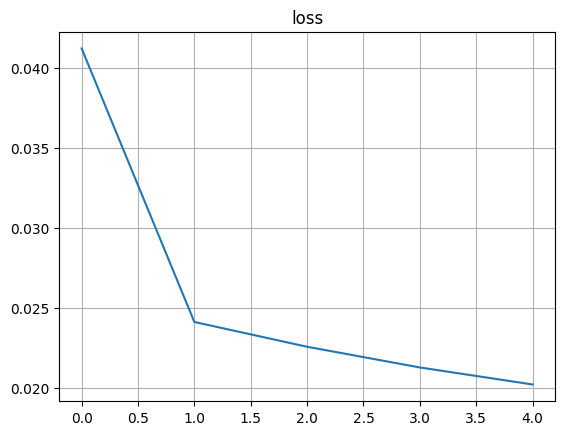

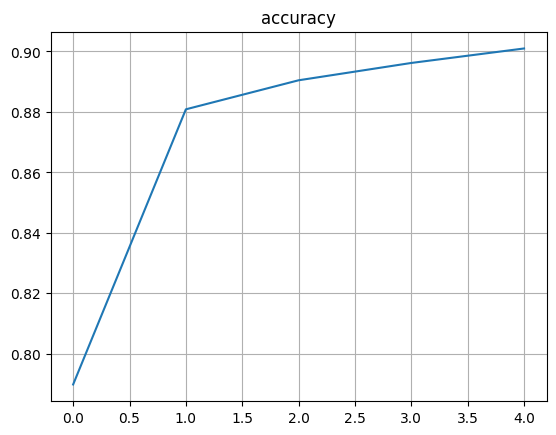

In [10]:
plt.plot(H["loss"])
plt.grid(True)
plt.title("loss")
plt.show()

plt.plot(H["accuracy"])
plt.grid(True)
plt.title("accuracy")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


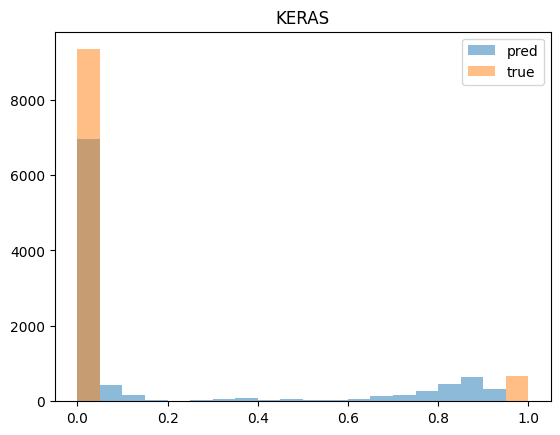

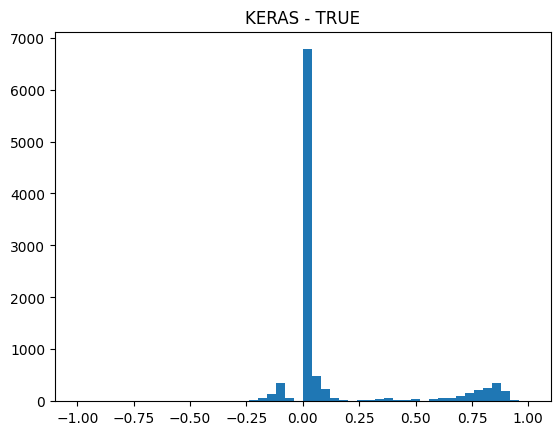

In [11]:
SAMPLE = 10000
y_pred = model.predict(x_data[:SAMPLE])[:,0]
y_true = y_data[:SAMPLE]
y_diff = y_pred - y_true

plt.hist(y_pred, bins=20, alpha=0.5, range=(0,1),label='pred')
plt.hist(y_true, bins=20, alpha=0.5, range=(0,1),label='true')
plt.legend()
plt.title("KERAS")
plt.show()

plt.hist(y_diff, bins=50, range=(-1,1))
plt.title("KERAS - TRUE")
plt.show()


In [12]:
import os
os.environ['PATH'] = '/HDD/Xilinx/Vivado/2023.2/bin:' + os.environ['PATH']

In [13]:
model.to_json()

'{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 15], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Dense", "config": {"name": "dense", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "kernel_constraint":

In [14]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='vitis')
# config = hls4ml.utils.config_from_keras_model(model, granularity='name')
# for layer in config['LayerName'].keys():
# config['Model']['Trace'] = True
config["Model"]["Precision"] = "ap_fixed<32,6>"
# print(config)
# for layer in config['LayerName'].keys():
#   config['LayerName'][layer]['Trace'] = True
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='nnscore_prj', part='xcu250-figd2104-2L-e'
)

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Interpreting Sequential
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: dense, layer type: Dense, input shapes: [[None, 15]], output shape: [None, 64]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 1]
-----------------------------------
Configuration
Model
  Precision:         ap_fixed<32,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
-----------------------------------
Interpreting Sequential
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: dense, layer type: Dense

/home/denis/UBUNTU_TEST/HitWarrior/nnscore_network/keras_env/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: input_layer, layer type: InputLayer, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: dense, layer type: Dense, input shapes: [[None, 15]], output shape: [None, 64]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 1]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

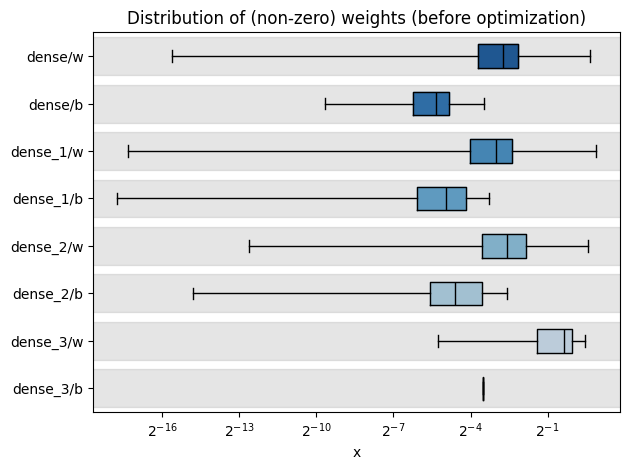

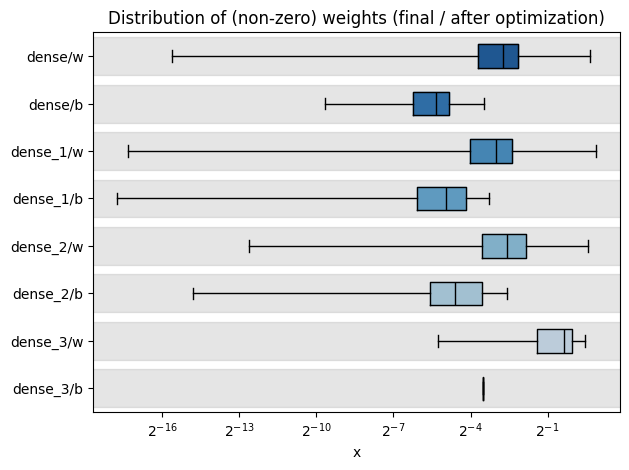

In [15]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

In [16]:
# hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [17]:
hls_model.compile()

Writing HLS project
Done


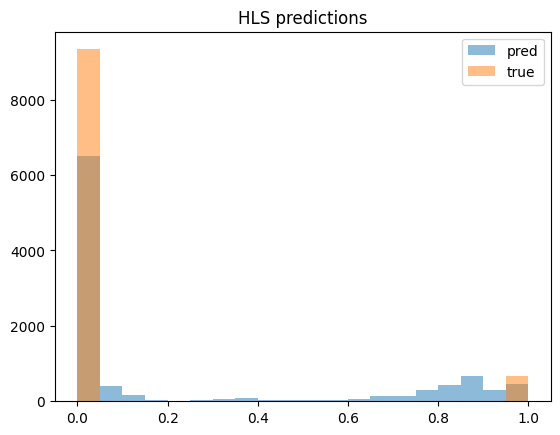

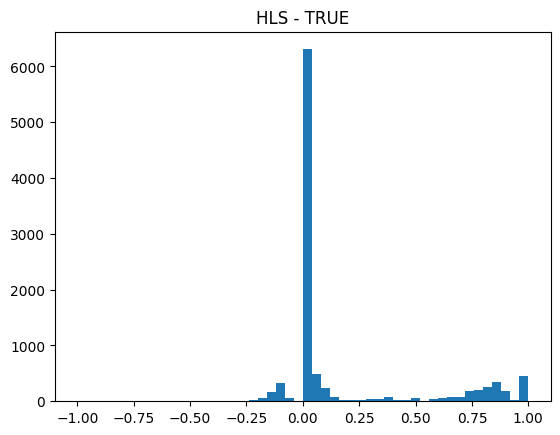

In [18]:
x_test = np.ascontiguousarray(x_data[:SAMPLE])
y_hls = hls_model.predict(x_test)[:,0]
# y_true = y_data[:SAMPLE] # already defined above
y_diff_hls = y_hls - y_true

plt.hist(y_hls, bins=20, alpha=0.5, range=(0,1),label='pred')
plt.hist(y_true, bins=20, alpha=0.5, range=(0,1),label='true')
plt.legend()
plt.title("HLS predictions")
plt.show()

plt.hist(y_diff_hls, bins=50, range=(-1,1))
plt.title("HLS - TRUE")
plt.show()

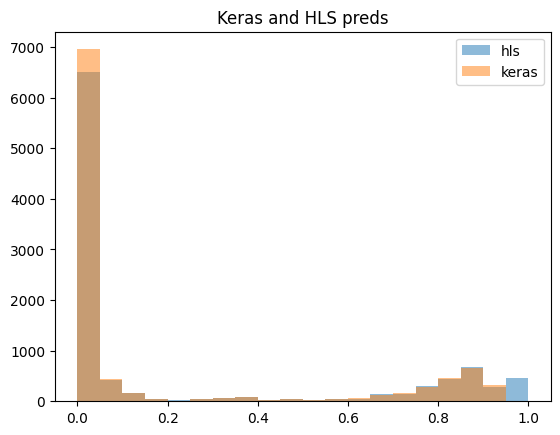

In [19]:
plt.hist(y_hls, bins=20, alpha=0.5, range=(0,1),label='hls')
plt.hist(y_pred, bins=20, alpha=0.5, range=(0,1),label='keras')
plt.legend()
plt.title("Keras and HLS preds")
plt.show()

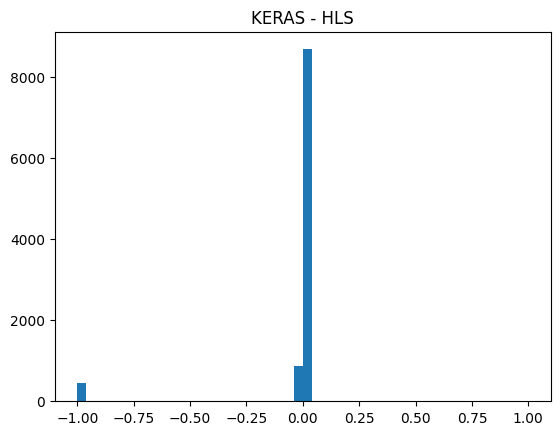

In [20]:
plt.hist(y_pred - y_hls, bins=50, range=(-1,1))
plt.title("KERAS - HLS")
plt.show()

In [21]:
# hls_pred, hls_trace = hls_model.trace(x_test[:1000])
# # test = keras.models.clone_model(model)
# # test.predict(x_data)
# keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, x_test[:1000])

In [22]:
# hls_trace

In [23]:
# keras_trace

In [24]:
# hls_pred

In [25]:
os.rename("nnscore_prj/firmware", "../src/kernels/nnscore_kernel")

mean 1 : 209.64
mean 2 : 278.18
mean 3 : 274.98
mean 4 : 240.29
mean 5 : 212.92


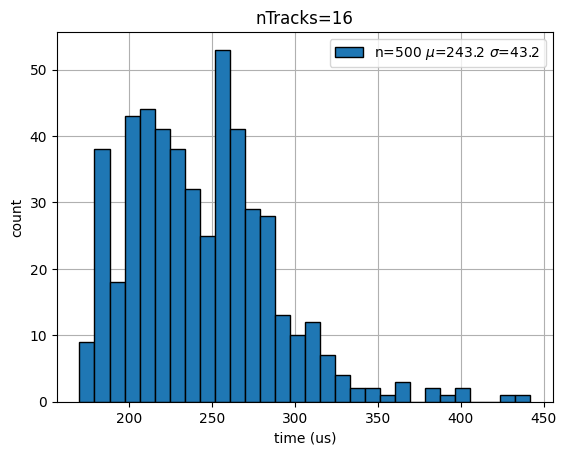

In [58]:
import numpy as np
import matplotlib.pyplot as plt

timings = []
tmp = [369, 212, 206, 225, 208, 190, 178, 183, 203, 218, 199, 187, 197, 317, 287, 191, 186, 181, 212, 188, 198, 311, 288, 215, 220, 178, 192, 191, 179, 197, 175, 268, 243, 202, 181, 239, 280, 231, 202, 198, 202, 295, 270, 286, 329, 204, 189, 184, 186, 192, 220, 185, 202, 193, 196, 198, 188, 189, 210, 187, 187, 186, 204, 199, 190, 181, 202, 170, 187, 205, 233, 179, 186, 188, 214, 187, 186, 203, 256, 253, 182, 190, 185, 222, 178, 186, 186, 228, 173, 190, 198, 175, 184, 222, 201, 209, 219, 201, 205, 204]
timings += tmp
print("mean 1 : {:.2f}".format(np.array(tmp).mean()))
tmp = [442, 380, 339, 328, 388, 301, 302, 251, 261, 259, 342, 322, 275, 252, 292, 256, 273, 314, 318, 344, 280, 255, 282, 266, 290, 279, 264, 243, 285, 262, 253, 266, 261, 257, 261, 303, 248, 260, 271, 244, 261, 250, 241, 234, 267, 263, 261, 285, 348, 301, 276, 271, 265, 262, 264, 252, 268, 261, 261, 256, 291, 324, 298, 259, 285, 293, 270, 279, 274, 277, 277, 306, 293, 301, 281, 284, 247, 240, 259, 264, 258, 265, 267, 262, 269, 255, 280, 265, 278, 272, 279, 273, 275, 244, 274, 244, 278, 249, 274, 239]
timings += tmp
print("mean 2 : {:.2f}".format(np.array(tmp).mean()))
tmp = [381, 355, 284, 324, 289, 314, 247, 293, 266, 269, 245, 281, 281, 284, 254, 292, 260, 277, 253, 308, 255, 286, 260, 263, 254, 268, 254, 333, 284, 309, 270, 274, 303, 318, 254, 281, 277, 312, 265, 361, 309, 327, 398, 319, 269, 259, 298, 312, 270, 307, 233, 303, 253, 281, 243, 240, 251, 252, 263, 250, 286, 262, 295, 255, 293, 263, 283, 265, 301, 286, 270, 252, 221, 273, 310, 263, 311, 259, 250, 249, 254, 252, 284, 253, 255, 254, 226, 251, 272, 286, 284, 256, 230, 220, 232, 215, 259, 206, 240, 247]
timings += tmp
print("mean 3 : {:.2f}".format(np.array(tmp).mean()))
tmp = [432, 273, 261, 211, 276, 215, 249, 216, 230, 226, 238, 223, 261, 265, 296, 222, 238, 226, 248, 231, 276, 240, 267, 217, 240, 218, 235, 228, 225, 367, 275, 252, 258, 221, 250, 236, 240, 253, 252, 208, 224, 242, 230, 258, 243, 216, 258, 258, 233, 236, 259, 232, 231, 206, 228, 231, 259, 202, 229, 252, 237, 201, 239, 226, 266, 233, 233, 219, 227, 204, 236, 198, 242, 262, 259, 225, 218, 207, 259, 237, 239, 220, 227, 239, 226, 248, 210, 207, 254, 236, 255, 207, 258, 230, 231, 240, 260, 235, 222, 235]
timings += tmp
print("mean 4 : {:.2f}".format(np.array(tmp).mean()))
tmp = [402, 230, 229, 221, 206, 214, 202, 205, 210, 236, 197, 217, 216, 215, 214, 225, 208, 216, 214, 215, 202, 202, 187, 187, 212, 227, 214, 242, 217, 216, 217, 209, 187, 214, 238, 198, 212, 188, 209, 215, 199, 212, 197, 204, 205, 211, 203, 216, 199, 217, 210, 203, 188, 219, 224, 209, 187, 215, 180, 200, 206, 188, 183, 192, 216, 212, 217, 214, 187, 215, 219, 183, 219, 240, 196, 208, 215, 219, 188, 228, 201, 185, 186, 216, 230, 202, 215, 256, 238, 210, 229, 248, 224, 229, 216, 214, 222, 216, 213, 214]
timings += tmp
print("mean 5 : {:.2f}".format(np.array(tmp).mean()))

timings = np.array(timings)

_, bins, _ = plt.hist(timings, bins=30, edgecolor='black', zorder=2, label=fr"n={len(timings)} $\mu$={timings.mean():.1f} $\sigma$={timings.std():.1f}")
plt.grid(True)
plt.legend()
plt.title("nTracks=16")
plt.xlabel("time (us)")
plt.ylabel("count")
plt.savefig("nTracks16.png", dpi=100)
plt.show()

min = bins[0]
max = bins[-1]

mean 1 : 233.13
mean 2 : 270.66
mean 3 : 264.51
mean 4 : 209.49
mean 5 : 219.76


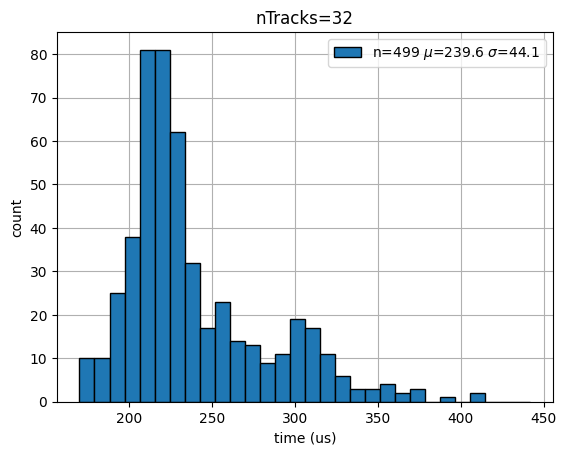

In [59]:

import numpy as np
import matplotlib.pyplot as plt

timings = []
tmp = [406, 327, 227, 291, 222, 232, 197, 242, 222, 231, 203, 234, 229, 230, 240, 220, 209, 229, 223, 232, 241, 237, 222, 261, 227, 235, 224, 261, 193, 240, 222, 209, 197, 243, 234, 218, 198, 229, 204, 235, 197, 233, 211, 232, 230, 250, 195, 250, 220, 297, 217, 303, 219, 306, 219, 303, 217, 300, 225, 299, 217, 305, 228, 323, 218, 316, 205, 299, 219, 241, 200, 256, 193, 235, 200, 231, 197, 205, 199, 219, 213, 204, 232, 229, 197, 234, 221, 212, 197, 240, 219, 206, 197, 217, 214, 209, 217, 215, 225, 210]
timings += tmp
print("mean 1 : {:.2f}".format(np.array(tmp).mean()))
tmp = [446, 328, 319, 308, 279, 300, 233, 289, 234, 319, 224, 293, 219, 304, 234, 314, 251, 297, 255, 359, 351, 365, 265, 317, 273, 303, 236, 302, 254, 311, 212, 313, 203, 370, 209, 259, 207, 246, 216, 346, 242, 306, 212, 320, 229, 308, 213, 307, 215, 293, 233, 302, 239, 309, 252, 293, 241, 324, 209, 309, 209, 286, 236, 305, 216, 289, 230, 273, 222, 269, 221, 275, 227, 310, 210, 309, 210, 310, 265, 275, 215, 300, 222, 294, 236, 321, 221, 278, 219, 268, 233, 322, 228, 270, 252, 262, 237, 320, 225, 277]
timings += tmp
print("mean 2 : {:.2f}".format(np.array(tmp).mean()))
tmp = [376, 344, 305, 391, 372, 354, 266, 304, 287, 352, 311, 353, 253, 339, 292, 333, 295, 286, 264, 335, 291, 329, 311, 330, 253, 341, 268, 287, 300, 293, 251, 287, 266, 255, 305, 285, 277, 316, 254, 314, 256, 272, 246, 267, 253, 258, 233, 260, 231, 260, 283, 235, 247, 246, 271, 249, 223, 275, 238, 261, 227, 253, 215, 246, 213, 223, 219, 210, 213, 280, 236, 256, 217, 213, 256, 236, 240, 224, 246, 247, 237, 216, 223, 208, 235, 228, 273, 272, 252, 217, 182, 222, 184, 216, 224, 208, 216, 246, 213, 220]
timings += tmp
print("mean 3 : {:.2f}".format(np.array(tmp).mean()))
tmp = [363, 328, 310, 225, 230, 200, 258, 204, 202, 228, 203, 193, 170, 198, 187, 192, 167, 199, 174, 215, 189, 229, 174, 252, 181, 228, 180, 228, 177, 231, 193, 229, 173, 228, 174, 227, 174, 207, 207, 226, 198, 231, 201, 233, 223, 212, 199, 203, 192, 226, 180, 207, 195, 209, 193, 221, 196, 232, 206, 199, 248, 236, 219, 197, 233, 228, 233, 192, 216, 203, 194, 187, 200, 217, 184, 202, 203, 207, 217, 176, 204, 170, 209, 198, 202, 193, 180, 201, 228, 206, 222, 193, 208, 216, 197, 208, 207, 177, 220]
timings += tmp
print("mean 4 : {:.2f}".format(np.array(tmp).mean()))
tmp = [410, 267, 231, 233, 221, 208, 214, 249, 215, 213, 214, 224, 213, 213, 216, 216, 228, 232, 224, 208, 216, 218, 217, 227, 207, 215, 213, 214, 216, 240, 226, 225, 204, 214, 224, 208, 235, 203, 217, 213, 214, 219, 209, 256, 208, 214, 218, 213, 216, 216, 215, 255, 205, 218, 214, 216, 217, 231, 204, 212, 227, 213, 212, 223, 208, 208, 225, 215, 212, 217, 216, 228, 207, 213, 215, 224, 223, 201, 215, 217, 216, 217, 215, 216, 249, 217, 210, 215, 213, 193, 210, 188, 215, 217, 214, 230, 203, 215, 225, 208]
timings += tmp
print("mean 5 : {:.2f}".format(np.array(tmp).mean()))

timings = np.array(timings)

plt.hist(timings, bins=30, range=(min,max), edgecolor='black', zorder=2, label=fr"n={len(timings)} $\mu$={timings.mean():.1f} $\sigma$={timings.std():.1f}")
plt.grid(True)
plt.legend()
plt.title("nTracks=32")
plt.xlabel("time (us)")
plt.ylabel("count")
plt.savefig("nTracks32.png", dpi=100)
plt.show()
